In [ ]:
!pip -q install "datasets<3.0.0" "evaluate<0.5.0" "transformers>=4.38,<4.45" \
                huggingface_hub torchaudio jiwer soundfile
!pip -q install -U fsspec==2025.3.0 gcsfs
!apt-get -y install sox libsox-dev libsox-fmt-all

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [ ]:
import os, sys, random, numpy as np, torch, datasets, evaluate, transformers, fsspec, gcsfs
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("transformers:", transformers.__version__)
print("python:", sys.version)

datasets: 2.21.0
evaluate: 0.4.5
transformers: 4.44.2
python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset, Audio, Dataset, concatenate_datasets, load_from_disk
from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
)
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from evaluate import load as load_metric
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) 재현성 고정 =====
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seed fixed:", SEED)

Seed fixed: 42


In [ ]:
SPLIT_DIR = "/content/cv16_splits_small"
n_train, n_val, n_test = 200, 100, 100
langs = ["ko", "ja", "en", "de"]

if os.path.isdir(SPLIT_DIR) and all(os.path.isdir(os.path.join(SPLIT_DIR, d)) for d in ["train","val","test"]):
    print("✅ Loading fixed splits from disk:", SPLIT_DIR)
    train_dataset = load_from_disk(os.path.join(SPLIT_DIR, "train"))
    val_dataset   = load_from_disk(os.path.join(SPLIT_DIR, "val"))
    test_dataset  = load_from_disk(os.path.join(SPLIT_DIR, "test"))
else:
    print("⚙️ Creating splits from streaming and saving to:", SPLIT_DIR)
    def take_valid(gen, n):
        out = []
        for ex in gen:
            if ex.get("audio") is not None and ex.get("sentence"):
                out.append(ex)
                if len(out) >= n: break
        return out

    train_data, val_data, test_data = [], [], []
    for lang in langs:
        print(f"Loading {lang}...")
        ds_tr = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="train",      streaming=True)
        ds_va = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="validation", streaming=True)
        ds_te = load_dataset("mozilla-foundation/common_voice_16_1", lang, split="test",       streaming=True)
        train_data += take_valid(ds_tr, n_train)
        val_data   += take_valid(ds_va, n_val)
        test_data  += take_valid(ds_te, n_test)

    random.shuffle(train_data); random.shuffle(val_data); random.shuffle(test_data)
    train_dataset = Dataset.from_list(train_data)
    val_dataset   = Dataset.from_list(val_data)
    test_dataset  = Dataset.from_list(test_data)
    os.makedirs(SPLIT_DIR, exist_ok=True)
    train_dataset.save_to_disk(os.path.join(SPLIT_DIR,"train"))
    val_dataset.save_to_disk(os.path.join(SPLIT_DIR,"val"))
    test_dataset.save_to_disk(os.path.join(SPLIT_DIR,"test"))
    print("✅ Saved fixed splits at", SPLIT_DIR)

print({ "train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset) })

⚙️ Creating splits from streaming and saving to: /content/cv16_splits_small
Loading ko...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mozilla-foundation/common_voice_16_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_16_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] ㅛ
The repository for mozilla-foundation/common_voice_16_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_16_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Reading metadata...: 401it [00:00, 1597.93it/s]
Reading metadata...: 235it [00:00, 1113.34it/s]
Reading metadata...: 282it [00:00, 904.09it/s]


Loading ja...


Reading metadata...: 9616it [00:00, 13355.00it/s]
Reading metadata...: 6094it [00:00, 9900.55it/s]
Reading metadata...: 6094it [00:00, 10271.55it/s]


Loading en...


Reading metadata...: 1090061it [00:23, 46842.17it/s]
Reading metadata...: 16390it [00:00, 26965.25it/s]
Reading metadata...: 16390it [00:00, 24772.00it/s]


Loading de...


Reading metadata...: 576207it [00:18, 30494.31it/s]
Reading metadata...: 16173it [00:00, 21590.34it/s]
Reading metadata...: 16173it [00:00, 20858.03it/s]


Saving the dataset (0/4 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

✅ Saved fixed splits at /content/cv16_splits_small
{'train': 800, 'val': 400, 'test': 400}


In [ ]:
TARGET_SR = 16000
model_checkpoint = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_checkpoint)
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

# 16kHz 캐스팅
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))
val_dataset   = val_dataset.cast_column("audio",   Audio(sampling_rate=TARGET_SR))
test_dataset  = test_dataset.cast_column("audio",  Audio(sampling_rate=TARGET_SR))

def prepare_dataset(example):
    audio = example["audio"]
    example["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=TARGET_SR).input_features[0]
    example["labels"] = processor.tokenizer(example["sentence"]).input_ids
    return example

# 훈련은 가볍게, 검증/테스트는 sentence 보존(디버깅 용)
keep_train = {"input_features","labels","locale"}
keep_eval  = {"input_features","labels","locale","sentence"}

processed_dataset_train = train_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in train_dataset.column_names if c not in keep_train]
)
processed_dataset_val = val_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in val_dataset.column_names if c not in keep_eval]
)
processed_dataset_test = test_dataset.map(
    prepare_dataset,
    remove_columns=[c for c in test_dataset.column_names if c not in keep_eval]
)

processed_dataset_train.set_format(columns=list(keep_train))
processed_dataset_val.set_format(columns=list(keep_eval))
processed_dataset_test.set_format(columns=list(keep_eval))

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
import torchaudio

def _to_tensor_1ch(x_np):
    x = torch.tensor(np.asarray(x_np, dtype=np.float32))
    if x.dim() == 1: x = x.unsqueeze(0)
    return x

def tempo_perturb_np(wav_np, sr, rate: float):
    if rate == 1.0:
        return wav_np, sr
    wav = _to_tensor_1ch(wav_np)
    effects = [["tempo", str(rate)]]  # 피치 보존
    aug, sr_out = torchaudio.sox_effects.apply_effects_tensor(wav, sr, effects)
    return aug.squeeze(0).numpy(), sr_out

def augment_copy(ds_raw, rate: float):
    def _aug(b):
        a = b["audio"]
        aug_np, sr_out = tempo_perturb_np(a["array"], a["sampling_rate"], rate)
        b["audio"] = {"array": aug_np, "path": None, "sampling_rate": sr_out}
        return b
    ds_aug = ds_raw.map(_aug)
    ds_proc = ds_aug.map(
        prepare_dataset,
        remove_columns=[c for c in ds_aug.column_names if c not in {"input_features","labels","locale"}]
    )
    ds_proc.set_format(columns=["input_features","labels","locale"])
    return ds_proc

# ----- 여기만 바꿔서 다양한 실험 -----
AUG_RATES = [0.7]                  # 예) [0.7] / [0.9] / [1.1] / [1.3] / [0.7,0.9,1.1,1.3]
AUG_RATIO_PER_RATE = 1.0           # 1.0이면 각 rate당 원본과 1:1 → all4면 (1+4)배
OUTPUT_DIR_SUFFIX = "r07"          # 폴더 구분용(예: r07, r11, all4 등)

In [ ]:
train_raw_16k = train_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SR))
aug_list = []
k = len(processed_dataset_train)
m_each = int(k * AUG_RATIO_PER_RATE)

for r in AUG_RATES:
    ds_aug = augment_copy(train_raw_16k, r)
    m = min(len(ds_aug), m_each)
    aug_list.append(ds_aug.shuffle(seed=SEED).select(range(m)))
    print(f"Aug rate {r}: using {m} / {len(ds_aug)}")

# 원본 + 모든 증강 합치기
proc_train_mix = concatenate_datasets([processed_dataset_train] + aug_list).shuffle(seed=SEED)
print("Train(orig):", len(processed_dataset_train), "→ Mixed:", len(proc_train_mix))

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/tmp/ipython-input-3590644533.py:13: UserWarning: torchaudio.sox_effects.sox_effects.apply_effects_tensor has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  aug, sr_out = torchaudio.sox_effects.apply_effects_tensor(wav, sr, effects)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Aug rate 0.7: using 800 / 800
Train(orig): 800 → Mixed: 1600


In [ ]:
# ===== 5) 모델/콜레이터/학습 =====
model = WhisperForConditionalGeneration.from_pretrained(model_checkpoint)
model.config.use_cache = False
# 학습 중 언어 강제 OFF (평가 시만 ON)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
# (안전) 디코더 시작/패드 토큰
start_id = processor.tokenizer.convert_tokens_to_ids("<|startoftranscript|>")
model.config.decoder_start_token_id = start_id
model.generation_config.decoder_start_token_id = start_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./whisper-small-aug_{OUTPUT_DIR_SUFFIX}",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,             # baseline과 동일(공정 비교)
    num_train_epochs=3,              # baseline과 동일
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",

    predict_with_generate=True,
    generation_max_length=225,

    remove_unused_columns=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=proc_train_mix,
    eval_dataset=processed_dataset_val,   # 검증은 원본만
    tokenizer=processor,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.166200,0.719698
2,0.018600,0.744427
3,0.001900,0.730484


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

TrainOutput(global_step=600, training_loss=0.24489091387329, metrics={'train_runtime': 1264.964, 'train_samples_per_second': 3.795, 'train_steps_per_second': 0.474, 'total_flos': 1.385209921536e+18, 'train_loss': 0.24489091387329, 'epoch': 3.0})

In [ ]:
LANG_NAME = {"ko":"korean", "ja":"japanese", "en":"english", "de":"german"}
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

def eval_on_with_samples(ds_proc, ds_raw, trainer_obj, label, sample_k=5, show_samples=True):
    rows = []
    for lang in ["ko","ja","en","de"]:
        subset_proc = ds_proc.filter(lambda x: x["locale"] == lang)
        subset_raw  = ds_raw.filter(lambda x: x["locale"] == lang)

        forced_ids = processor.get_decoder_prompt_ids(language=LANG_NAME[lang], task="transcribe")
        trainer_obj.model.generation_config.forced_decoder_ids = forced_ids
        trainer_obj.model.generation_config.max_length = 225

        out = trainer_obj.predict(subset_proc)
        preds = processor.tokenizer.batch_decode(out.predictions, skip_special_tokens=True)
        # -100 마스크를 패드로 치환 후 디코딩
        label_ids = np.where(out.label_ids != -100, out.label_ids, processor.tokenizer.pad_token_id)
        refs  = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        wer = wer_metric.compute(predictions=preds, references=refs)
        cer = cer_metric.compute(predictions=preds, references=refs)
        rows.append({"set": label, "lang": lang, "WER": wer, "CER": cer, "N": len(refs)})

        if show_samples and sample_k > 0:
            raw_texts = subset_raw["sentence"] if "sentence" in subset_raw.column_names else None
            print(f"\n[{label}] {lang.upper()} samples (k={sample_k})")
            for i,(p,r) in enumerate(zip(preds, refs)):
                if i >= sample_k: break
                print(f"#{i:02d} PRED: {p}")
                print(f"     REF(dec): {r}")
                if raw_texts is not None:
                    print(f"     REF(raw): {raw_texts[i]}")
                print("---")

    return pd.DataFrame(rows).sort_values("lang")

df_test = eval_on_with_samples(
    processed_dataset_test, test_dataset,
    trainer, label=f"test_orig_{OUTPUT_DIR_SUFFIX}",
    sample_k=5, show_samples=True
)

display(df_test)
out_csv = f"/content/results_small_aug_{OUTPUT_DIR_SUFFIX}_test_orig.csv"
df_test.to_csv(out_csv, index=False)
print("Saved ->", out_csv)

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



[test_orig_r07] KO samples (k=5)
#00 PRED: 그러나 실제로 뽑은 숫자는 지난주에 빚지 못한 것으로 나타났다.
     REF(dec): 그러나 실제로 뽑은 숫자는 지난 주에 미치지 못한 것으로 나타났다.
     REF(raw): 그러나 실제로 뽑은 숫자는 지난 주에 미치지 못한 것으로 나타났다.
---
#01 PRED: 신압대는 이렇게 말하며 유서방을 검눈질 해보았다.
     REF(dec): 싱앗대는 이렇게 말하며 유서방을 곁눈질해 보았다.
     REF(raw): 싱앗대는 이렇게 말하며 유서방을 곁눈질해 보았다.
---
#02 PRED: 신철이는 어찌보면 감정을 가진 사람같이 안아보았다.
     REF(dec): 신철이는 어찌 보면 감정을 가진 사람 같지 않아 보였다.
     REF(raw): 신철이는 어찌 보면 감정을 가진 사람 같지 않아 보였다.
---
#03 PRED: 내다보니까 온다 어려웠던 집에 불이 붙으며 사람들이 왔다갔다 야단이었습니다.
     REF(dec): 내다보니까 언덕 아래 어떤 집에 불이 붙으며 사람들이 왔다갔다 야단이었습니다.
     REF(raw): 내다보니까 언덕 아래 어떤 집에 불이 붙으며 사람들이 왔다갔다 야단이었습니다.
---
#04 PRED:  일력화가 무거워 지네 그의 몸은 이상은 가벼졌고
     REF(dec): 인력거가 무거워지매 그의 몸은 이상하게도 가벼워졌고
     REF(raw): 인력거가 무거워지매 그의 몸은 이상하게도 가벼워졌고
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig_r07] JA samples (k=5)
#00 PRED: 福島県広野町
     REF(dec): 福島県広野町
     REF(raw): 福島県広野町
---
#01 PRED: だが言葉の
     REF(dec): だが断る
     REF(raw): だが断る
---
#02 PRED: そして、いくら未来としても、君が悪ければ、我は書いて、その紙を、じっと見つめないではいられませんでした。
     REF(dec): そして、いくら見まいとしても、きみが悪ければ悪いほど、かえってその影を、じっと見つめないではいられませんでした。
     REF(raw): そして、いくら見まいとしても、きみが悪ければ悪いほど、かえってその影を、じっと見つめないではいられませんでした。
---
#03 PRED: ニーナザク選手のシュートは、ハノファである。
     REF(dec): ニーダーザクセン州の州都はハノーファーである
     REF(raw): ニーダーザクセン州の州都はハノーファーである
---
#04 PRED: そこで自分で出がけて行って、調べ始めました。彼はさんざん探し回りました。
     REF(dec): そこで自分で出かけて行って、調べはじめました。かれはさんざんさがしまわりました。
     REF(raw): そこで自分で出かけて行って、調べはじめました。かれはさんざんさがしまわりました。
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig_r07] EN samples (k=5)
#00 PRED: A long period belongs to the class of notes, although not a lot of good coverage.
     REF(dec): Enoxaparin belongs to the class of drugs known as low molecular weight heparins.
     REF(raw): Enoxaparin belongs to the class of drugs known as low molecular weight heparins.
---
#01 PRED: Eight.
     REF(dec): eight
     REF(raw): eight
---
#02 PRED: Do you mean it?
     REF(dec): Do you mean it?
     REF(raw): Do you mean it?
---
#03 PRED: You shall see the other guy, especially how good at fighting him.
     REF(dec): You should see the other guy, specifically, how good at fighting he is.
     REF(raw): You should see the other guy, specifically, how good at fighting he is.
---
#04 PRED: Karina's would enough of dancing with the stars, most of the following month.
     REF(dec): Karina Smirnoff of "Dancing With The Stars" hosted the following month.
     REF(raw): Karina Smirnoff of "Dancing With The Stars" hosted the following month.
---


Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]


[test_orig_r07] DE samples (k=5)
#00 PRED: Wenn nicht, dann läck man sie ja in Durchchirmen in der Platsche.
     REF(dec): Wenn nicht, dann legt man sie irgendwo hin, wo Platz ist.
     REF(raw): Wenn nicht, dann legt man sie irgendwo hin, wo Platz ist.
---
#01 PRED: Wie ist die derzeitige Verkehrssituation?
     REF(dec): Wie ist die derzeitige Verkehrssituation?
     REF(raw): Wie ist die derzeitige Verkehrssituation?
---
#02 PRED: Aus dem Prozess hat er den Bezirk in Bevorgen den Kanalten Kischern zu bekommen.
     REF(dec): Aus den Prozessakten der Hexenverfolgung sind keine authentischen Rezepte bekannt.
     REF(raw): Aus den Prozessakten der Hexenverfolgung sind keine authentischen Rezepte bekannt.
---
#03 PRED: Er er rang den ersten Platz in seiner Hupraumklasse.
     REF(dec): Er errang den ersten Platz in seiner Hubraumklasse.
     REF(raw): Er errang den ersten Platz in seiner Hubraumklasse.
---
#04 PRED: Auch du schränkt!
     REF(dec): Ach du Schreck!
     REF(raw): Ach 

,set,lang,WER,CER,N
3,test_orig_r07,de,0.449344,0.181755,100
2,test_orig_r07,en,0.321788,0.164030,100
1,test_orig_r07,ja,0.855856,0.485922,100
0,test_orig_r07,ko,0.476636,0.204017,100


Saved -> /content/results_small_aug_r07_test_orig.csv


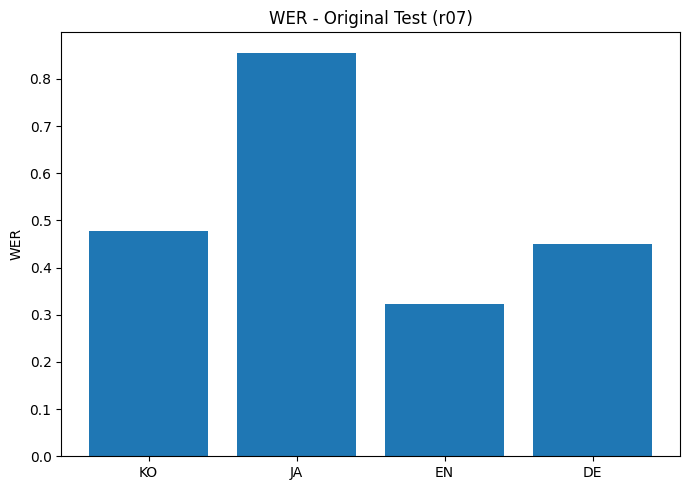

In [ ]:
plt.figure(figsize=(7,5))
langs_plot = ["ko","ja","en","de"]
vals = [df_test[df_test["lang"]==l]["WER"].values[0] for l in langs_plot]
plt.bar([l.upper() for l in langs_plot], vals)
plt.title(f"WER - Original Test ({OUTPUT_DIR_SUFFIX})")
plt.ylabel("WER"); plt.tight_layout(); plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

LOCAL_DIR   = "/content/cv16_splits_small"                     # 지금 있는 폴더
PERSIST_DIR = "/content/drive/MyDrive/data/asr_splits/cv16_v1"      # 드라이브에 저장할 곳

import os, shutil
os.makedirs(PERSIST_DIR, exist_ok=True)

# 이미 복사돼 있지 않다면 복사
if not os.path.isdir(f"{PERSIST_DIR}/train"):
    shutil.copytree(f"{LOCAL_DIR}/train", f"{PERSIST_DIR}/train")
    shutil.copytree(f"{LOCAL_DIR}/val",   f"{PERSIST_DIR}/val")
    shutil.copytree(f"{LOCAL_DIR}/test",  f"{PERSIST_DIR}/test")
    print("✅ Copied splits to Drive:", PERSIST_DIR)
else:
    print("✅ Splits already exist on Drive:", PERSIST_DIR)

Mounted at /content/drive
✅ Copied splits to Drive: /content/drive/MyDrive/data/asr_splits/cv16_v1
